## Model evaluation

In [207]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import RobustScaler, StandardScaler
from scipy import stats
from sklearn.preprocessing import OneHotEncoder
import tensorflow as tf
from tensorflow import keras
from sklearn.model_selection import train_test_split
import scipy.signal as signal
from sklearn.metrics import confusion_matrix, plot_confusion_matrix
import seaborn as sns
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.models import Sequential
import warnings
warnings.filterwarnings('ignore')

### 1. Evaluating the models with the MS and WISDM datasets

In [5]:
#Reading the testing datasets
df_ms = pd.read_csv('./01_rawdata/raw_ms_all0926_df.csv') # read in the ms datasets
df_wd = pd.read_csv('./01_rawdata/raw_wisdm0926_df.csv')  # read in the wisdm datasets

In [6]:
# Manually setup training and testing datasets for both WISDM and MS
df_wd_train = df_wd[df_wd['user_id'] <= 30]
df_wd_test = df_wd[df_wd['user_id'] > 30]
df_ms_train = df_ms[df_ms['user_id'] <= 66]
df_ms_test = df_ms[df_ms['user_id'] > 66]

In [123]:
#define a function to scale the features for building the models
def robustscale_data(df_train,df_test,cols,scaler=RobustScaler()):
    scale_columns = cols
    scaler = scaler.fit(df_train[scale_columns])
    df_train.loc[:, scale_columns] = scaler.transform(df_train[scale_columns].to_numpy())
    df_test.loc[:, scale_columns] = scaler.transform(df_test[scale_columns].to_numpy())
    return df_train,df_test

In [69]:
# scale the acceleration in the WISDM datasets
df_wd_train,df_wd_test = robustscale_data(df_wd_train,df_wd_test,['x_axis', 'y_axis', 'z_axis'])

In [70]:
# scale the acceleration in the MS datasets
df_ms_train,df_ms_test = robustscale_data(df_ms_train,df_ms_test,['x_axis', 'y_axis', 'z_axis'])
df_ms_test.head()

,attitude.roll,attitude.pitch,attitude.yaw,gravity.x,gravity.y,gravity.z,rotationRate.x,rotationRate.y,rotationRate.z,userAcceleration.x,...,weight,height,age,gender,trial,x_axis,y_axis,z_axis,user_id,activity
992434,-0.224624,-0.286674,-0.164736,-0.231529,0.140885,-0.157092,0.197856,1.037395,-1.158822,-0.474556,...,54.0,164.0,26.0,0.0,1.0,-0.298364,-0.334976,-0.173145,67.0,Downstairs
992435,-0.228428,-0.279494,-0.175891,-0.238157,0.138718,-0.166885,0.780960,1.436103,-1.416717,-0.270637,...,54.0,164.0,26.0,0.0,1.0,-0.271320,-0.550886,-0.213503,67.0,Downstairs
992436,-0.235533,-0.268435,-0.190086,-0.250021,0.135243,-0.181463,1.037861,0.825558,-2.016847,0.953937,...,54.0,164.0,26.0,0.0,1.0,-0.085477,-0.587546,-0.309718,67.0,Downstairs
992437,-0.244925,-0.255494,-0.205022,-0.265793,0.130959,-0.197812,1.085719,0.366568,-2.015011,2.156050,...,54.0,164.0,26.0,0.0,1.0,0.093497,-0.558702,-0.274414,67.0,Downstairs
992438,-0.251631,-0.244433,-0.216293,-0.278595,0.127118,-0.211785,0.846843,0.582612,-1.597334,1.865288,...,54.0,164.0,26.0,0.0,1.0,0.036266,-0.380323,-0.100965,67.0,Downstairs


In [10]:
#Credit to in this reference(https://towardsdatascience.com/time-series-classification-for-human-activity-recognition-with-lstms-using-tensorflow-2-and-keras-b816431afdff)
def create_dataset(X, y, time_steps=1, step=1):
    '''
    This function creats the timeseries data from the raw datasets.
    X: The input features for building the model
    y: The labels for the corresponding input dataset
    time_step: The window length (number of samples in the time series) of each of the training datasets
    step: The moving distance for the window to generate the next training datasets.
    The difference from (time_step - step) gives the number of overlapping samples between the two nearby rows of training dataset.
    '''
    Xs, ys = [], []
    for i in range(0, len(X) - time_steps, step):
        v = X.iloc[i:(i + time_steps)].values
        labels = y.iloc[i: i + time_steps]
        Xs.append(v)
        ys.append(stats.mode(labels)[0][0])
    return np.array(Xs), np.array(ys).reshape(-1, 1)

In [11]:
#define a function to scan the window length and window shifting step

def create_train_test(time_steps,step,df_train = df_wd_train, df_test = df_wd_test,start=-3,end=None):
    
    # Create training datasets 
    X2_wd_train, y2_wd_train = create_dataset(
    df_train[df_train.columns[start:end]],
    df_train.activity,
    time_steps,
    step)
    # Create testing datasets
    X2_wd_test, y2_wd_test = create_dataset(
    df_test[df_test.columns[start:end]],
    df_test.activity,
    time_steps,
    step)
    
    return X2_wd_train, y2_wd_train, X2_wd_test, y2_wd_test

<a name="1.1ml"></a>
#### 1.1 Evaluate the models built from the combined datasets

In [13]:
# Creating training and testing datasets used to build models by activities, and then merge all together
activity_list = list(set(df_wd['activity']))
time_steps = 80
step = 16
X2_wd_train = np.zeros((0,time_steps,3))
y2_wd_train = np.zeros((0,1))
X2_wd_test = np.zeros((0,time_steps,3))
y2_wd_test = np.zeros((0,1))
for act in activity_list:
    X1,y1,X2,y2 = create_train_test(time_steps=time_steps,step=step,df_train=df_wd_train[df_wd_train['activity']==act],df_test=df_wd_test[df_wd_test['activity']==act])
    X2_wd_train = np.append(X2_wd_train,X1,axis=0)
    y2_wd_train = np.append(y2_wd_train,y1,axis=0)
    X2_wd_test = np.append(X2_wd_test,X2,axis=0)
    y2_wd_test = np.append(y2_wd_test,y2,axis=0)

In [14]:
X2_wd_train_resample = signal.resample(X2_wd_train,200,axis=1)
X2_wd_test_resample = signal.resample(X2_wd_test,200,axis=1)

In [15]:
# create one hot encoder for labels
enc = OneHotEncoder(handle_unknown='ignore', sparse=False)

enc = enc.fit(y2_wd_train)

y2_wd_train = enc.transform(y2_wd_train)
y2_wd_test = enc.transform(y2_wd_test)

In [16]:
# Creating training and testing datasets used to build models by activities, and then merge all together
X_ms_train = np.zeros((0,200,3))
y_ms_train = np.zeros((0,1))
X_ms_test = np.zeros((0,200,3))
y_ms_test = np.zeros((0,1))
for act in activity_list:
    X1,y1,X2,y2 = create_train_test(time_steps=200,step=40,df_train=df_ms_train[df_ms_train['activity']==act],df_test=df_ms_test[df_ms_test['activity']==act],start=17,end=20)
    X_ms_train = np.append(X_ms_train,X1,axis=0)
    y_ms_train = np.append(y_ms_train,y1,axis=0)
    X_ms_test = np.append(X_ms_test,X2,axis=0)
    y_ms_test = np.append(y_ms_test,y2,axis=0)

In [18]:
y_ms_test = enc.transform(y_ms_test)

In [19]:
X_cb_test = np.concatenate((X2_wd_test_resample,X_ms_test),axis = 0 )
y_cb_test = np.concatenate((y2_wd_test,y_ms_test),axis = 0 )
print(X_cb_test.shape,y_cb_test.shape)

(22947, 200, 3) (22947, 6)


In [20]:
# Define a function to reshape the datasets for CNN models
def reshape_4cnn(X):
    X = np.array(X).reshape(X.shape[0],X.shape[1],X.shape[2],1)
    return X

In [31]:
X_wd_test_rs = reshape_4cnn(X2_wd_test_resample)
X_ms_test_rs = reshape_4cnn(X_ms_test)
X_cb_test_rs = reshape_4cnn(X_cb_test)

Now the testing datasets (3 features) for the WISDM, MS, and combined datasets are ready

In [32]:
print(X_wd_test_rs.shape,X_ms_test_rs.shape,X_cb_test_rs.shape)

(12464, 200, 3, 1) (10483, 200, 3, 1) (22947, 200, 3, 1)


In [199]:
# Load the CNN models for evaluation
# 3 CNN models built in section 6 will be evaluated:

# The CNN model built from the combined MS and WISDM datasets (only 3 features are available for combined datasets)
model_cb = tf.keras.models.load_model('./02_models/1002cb_cnn_md_3lay_epo20.h5')

# The CNN model built from the MS dataset using 12 features
model_12ms4 = tf.keras.models.load_model('./02_models/1002ms_cnn_12md_epo20_3layv2.h5')

# The CNN model built from the MS dataset using 12 feature, and all subjects were included in training datasets
model_12ms = tf.keras.models.load_model('./02_models/1002ms_cnn_12md_epo20_3layv2_allsubject.h5')

In [56]:
# define a function to output the confusion matrix
def plot_cm(X,y_true,md,enc = None):
#   Input: X: the testing dataset
#          y: the true labels for the testing datasets
#          md: the model need to create predicting values
#          enc: The operator to transform the labels into 1 column vector
#   Output: the confusion matrix and the normalized confusion matrix
    preds = md.predict(X)
    cm = confusion_matrix(enc.inverse_transform(y_true),enc.inverse_transform(preds))
    cm_nm = confusion_matrix(enc.inverse_transform(y_true),enc.inverse_transform(preds),normalize='true')
    fig=plt.figure(figsize = (16,6))
    ax1=fig.add_subplot(121)
    plt.margins(x=0.1)
    ax2=fig.add_subplot(122)
    sns.heatmap(cm,
            cmap='Blues',
            annot=True,fmt='',
            xticklabels=['Downstairs', 'Jogging', 'Sitting', 'Standing', 'Upstairs',
        'Walking'],
           yticklabels=['Downstairs', 'Jogging', 'Sitting', 'Standing', 'Upstairs',
        'Walking'],
            vmax = 1000,
                ax=ax1
            #cbar_kws = {'ticks':[0,1200]}
           )
    ax1.set(xlabel='Prediction',ylabel='True label')
    
    sns.heatmap(cm_nm,
            cmap='Blues',
            annot=True,fmt='.2f',
            xticklabels=['Downstairs', 'Jogging', 'Sitting', 'Standing', 'Upstairs',
        'Walking'],
           yticklabels=['Downstairs', 'Jogging', 'Sitting', 'Standing', 'Upstairs',
        'Walking'],
        ax=ax2,
            #cbar_kws = {'ticks':[0,1200]}
           )
    ax2.set(xlabel='Prediction',ylabel='True label');
    return cm, cm_nm

In [73]:
# CNN model's accuracy on the WISDM datasets
model_cb.evaluate(X_wd_test_rs,y2_wd_test)

390/390 [==============================] - 11s 29ms/step - loss: 0.6929 - accuracy: 0.93790s -


[0.6928592920303345, 0.9379011392593384]

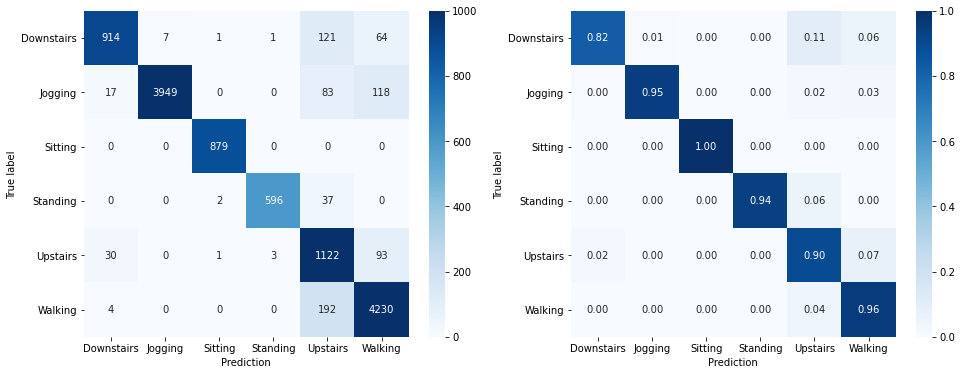

In [71]:
# The confusion matrix for the combined model on the WISDM testing dataset
plot_cm(X_wd_test_rs,y2_wd_test,model_cb,enc=enc)

In [74]:
# CNN model's accuracy on the MS datasets
model_cb.evaluate(X_ms_test_rs,y_ms_test)

328/328 [==============================] - 10s 31ms/step - loss: 0.8108 - accuracy: 0.9014


[0.8108214139938354, 0.9013640880584717]

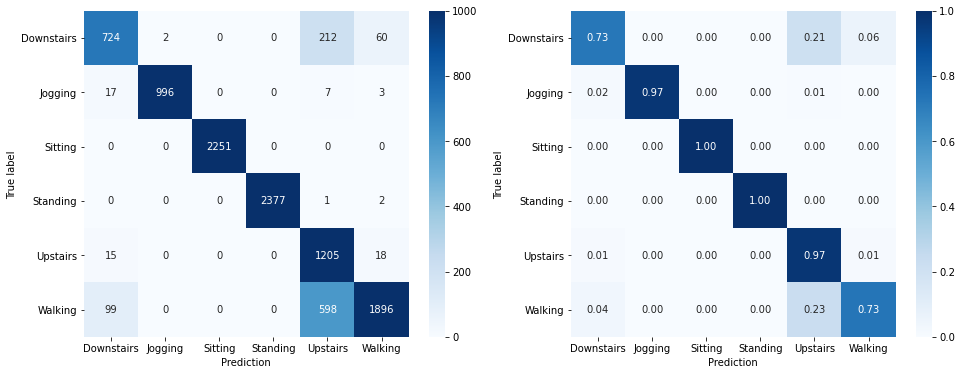

In [58]:
# The confusion matrix for the combined model on the MS testing dataset
plot_cm(X_ms_test_rs,y_ms_test,model_cb,enc=enc)

In [75]:
# CNN model's accuracy on the combined MS and WISDM datasets
model_cb.evaluate(X_cb_test_rs,y_cb_test)

718/718 [==============================] - 24s 33ms/step - loss: 0.7467 - accuracy: 0.9212


[0.7467480301856995, 0.9212097525596619]

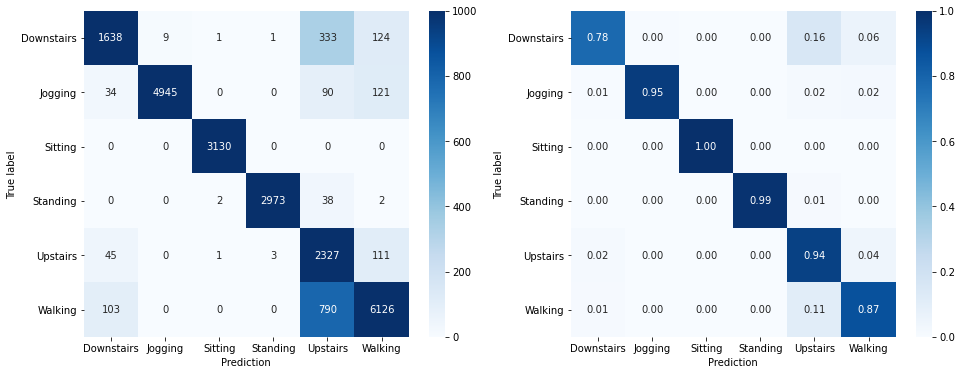

In [59]:
# The confusion matrix for the combined model on the combined testing dataset
plot_cm(X_cb_test_rs,y_cb_test,model_cb,enc=enc)

- The CNN model built from the combined datasets had the following classification accuracies    

|     	| WISDM dataset 	| MS dataset  	| Combined dataset 	|   
|-------------	|-------	|------	|----------	|   
| Accuracy   	| 0.94  	| 0.90 	| 0.92     	|  
- From the confusion matrix, one can see that the model could classify some of the activies (such as jogging, sitting, standing and upstairs) more accurate than other activities (such as downstairs and walking).

<a name="1.2ml"></a>
#### 1.2 Evaluate the models built from the MS datasets (12 features)

In [60]:
# Select all the featuers collected by iPhones (Attitude, gravity, rotation rate, and user acceleration)
cols_12 = df_ms.columns[:12]

In [72]:
# scale the all the selected features in the MS datasets
df_ms_train,df_ms_test = robustscale_data(df_ms_train,df_ms_test,cols_12)
df_ms_test.head()

,attitude.roll,attitude.pitch,attitude.yaw,gravity.x,gravity.y,gravity.z,rotationRate.x,rotationRate.y,rotationRate.z,userAcceleration.x,...,weight,height,age,gender,trial,x_axis,y_axis,z_axis,user_id,activity
992434,-0.224624,-0.286674,-0.164736,-0.231529,0.140885,-0.157092,0.197856,1.037395,-1.158822,-0.474556,...,54.0,164.0,26.0,0.0,1.0,-0.298364,-0.334976,-0.173145,67.0,Downstairs
992435,-0.228428,-0.279494,-0.175891,-0.238157,0.138718,-0.166885,0.780960,1.436103,-1.416717,-0.270637,...,54.0,164.0,26.0,0.0,1.0,-0.271320,-0.550886,-0.213503,67.0,Downstairs
992436,-0.235533,-0.268435,-0.190086,-0.250021,0.135243,-0.181463,1.037861,0.825558,-2.016847,0.953937,...,54.0,164.0,26.0,0.0,1.0,-0.085477,-0.587546,-0.309718,67.0,Downstairs
992437,-0.244925,-0.255494,-0.205022,-0.265793,0.130959,-0.197812,1.085719,0.366568,-2.015011,2.156050,...,54.0,164.0,26.0,0.0,1.0,0.093497,-0.558702,-0.274414,67.0,Downstairs
992438,-0.251631,-0.244433,-0.216293,-0.278595,0.127118,-0.211785,0.846843,0.582612,-1.597334,1.865288,...,54.0,164.0,26.0,0.0,1.0,0.036266,-0.380323,-0.100965,67.0,Downstairs


In [62]:
# Creating training and testing datasets used to build models by activities, then merge all together
X2_ms_train = np.zeros((0,200,12))
y2_ms_train = np.zeros((0,1))
X2_ms_test = np.zeros((0,200,12))
y2_ms_test = np.zeros((0,1))
for act in activity_list:
    X1,y1,X2,y2 = create_train_test(time_steps=200,step=40,df_train=df_ms_train[df_ms_train['activity']==act],df_test=df_ms_test[df_ms_test['activity']==act],start=0,end=12)
    X2_ms_train = np.append(X2_ms_train,X1,axis=0)
    y2_ms_train = np.append(y2_ms_train,y1,axis=0)
    X2_ms_test = np.append(X2_ms_test,X2,axis=0)
    y2_ms_test = np.append(y2_ms_test,y2,axis=0)

In [63]:
enc = OneHotEncoder(handle_unknown='ignore', sparse=False)

enc = enc.fit(y2_ms_train)

y2_ms_train = enc.transform(y2_ms_train)
y2_ms_test = enc.transform(y2_ms_test)

In [64]:
X2_ms_test_rs = reshape_4cnn(X2_ms_test)

In [76]:
model_12ms4.evaluate(X2_ms_test_rs,y2_ms_test)

328/328 [==============================] - 70s 213ms/step - loss: 0.6886 - accuracy: 0.9298


[0.6885741949081421, 0.9297910928726196]

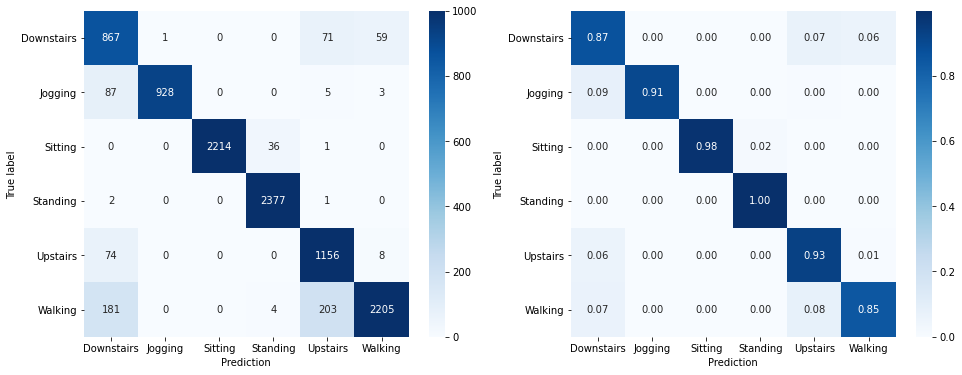

In [67]:
plot_cm(X2_ms_test_rs,y2_ms_test,model_12ms4,enc=enc)

In [77]:
model_12ms.evaluate(X2_ms_test_rs,y2_ms_test)

328/328 [==============================] - 64s 194ms/step - loss: 0.0270 - accuracy: 0.9941


[0.026988819241523743, 0.9940856695175171]

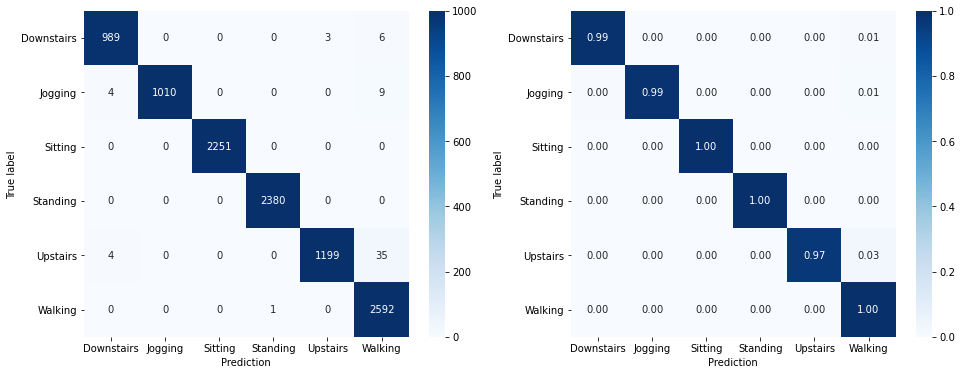

In [65]:
plot_cm(X2_ms_test_rs,y2_ms_test,model_12ms,enc=enc)

- The CNN model built from the MS datasets using all 12 feature had high classification accuracies, especially when using all subjects in training, the accuracy was almost perfect.  

|All subjects in training     	|  No 	| Yes  	|
|-------------	|-------	|------	|  
| Accuracy   	| 0.93  	| 0.99 	|  
- From the confusion matrix, one can have similar observations that the model could classify some of the activies (such as jogging, sitting, standing and upstairs) more accurate than other activities (such as downstairs and walking) for the first case. However, when all subjects' data was used in training, the model have great accuracies for all activities.

<a name="2ml"></a>
### 2. Evaluate the models with dataset collected by myself

<a name="2.1ml"></a>
#### 2.1 Model accuracy

In [149]:
#define a function to reading the datasets I collected
def read_in_iPhone_data(path = './01_rawdata/collection/', file = 'z_walk1.csv', merge_wd = True):
    #input: path -> the folder where the collected data was saved
    #       file -> the name of the file which contains the collected data
    #       merge_wd -> Where the data will work with the WIDSM related model. default: True (3 featuers to read in), False (12 features to read in)
    #output: df -> Output of the collected in pandas DataFrame
    
    df = pd.read_csv(path+file)
    df['x_axis']=df['userAcceleration.x']+df['gravity.x']
    df['y_axis']=df['userAcceleration.y']+df['gravity.y']
    df['z_axis']=df['userAcceleration.z']+df['gravity.z']
    if merge_wd:      # only need 3 featuress if work with WISDM datasets
        return df[['x_axis','y_axis','z_axis']]
    else:             # all the features could be used if work with MS datasets
        col = ['attitude.roll', 'attitude.pitch',
       'attitude.yaw', 'gravity.x', 'gravity.y', 'gravity.z',
       'rotationRate.x', 'rotationRate.y',
       'rotationRate.z', 'userAcceleration.x', 'userAcceleration.y',
       'userAcceleration.z']
        return df[col]    

In [147]:
#define a function to scale the features, the scaler need to match with the ones used for building the models
def robustscale_data(df,cols,scaler=RobustScaler()):
    scale_columns = cols
    df.loc[:, scale_columns] = scaler.fit_transform(df[scale_columns].to_numpy())
    return df

In [81]:
df = read_in_iPhone_data()

In [82]:
df.head()

,x_axis,y_axis,z_axis
0,0.121612,-0.494126,-0.931396
1,0.125077,-0.517579,-0.988495
2,0.105133,-0.492829,-1.029984
3,0.053482,-0.464905,-0.957855
4,0.029190,-0.445298,-0.990738


In [83]:
df = robustscale_data(df,['x_axis', 'y_axis', 'z_axis'])

In [84]:
df.tail()

,x_axis,y_axis,z_axis
13976,1.727623,-3.970266,-2.409552
13977,1.720784,-3.962965,-2.390196
13978,1.598563,-3.953000,-2.368218
13979,1.608809,-4.018720,-2.419286
13980,1.569607,-4.032458,-2.359924


In [150]:
def create_dataset_X(X, time_steps=1, step=1):
    '''
    This function creats the timeseries data for model building from the raw datasets.
    X: The input features for building the model
    time_step: The window length (number of samples in the time series) of each of the training datasets
    step: The moving distance for the window to generate the next training datasets.
    The difference from (time_step - step) gives the number of overlapped samples between the two nearby rows of the model building datasets.
    '''
    Xs, ys = [], []
    for i in range(0, len(X) - time_steps, step):
        v = X.iloc[i:(i + time_steps)].values
        Xs.append(v)
    return np.array(Xs)

In [151]:
#define a function to mapping the model's prediciton to activities
def map_preds(pred):
    out = []
    act_dict = {0:'Downstairs', 1:'Jogging', 2:'Sitting', 3:'Standing', 4:'Upstairs',
        5:'Walking'}    
    for i in range(pred.shape[0]):
        out.append(act_dict[np.argmax(pred[i])])
    return out        

In [336]:
#Evaluate the collected data by the model built from the combined MS and WISDM datasets
#Here, I have collected 8 activities 4 subjects. The file first letter of the file name stands for the id of the subject, then the activity.
#Some of the activies of a subject were collected multiple times, so that there is a number followed the activies in the name.
#All the files were collected by putting the iPhone in the right pocket of trousers (The same as the MS datasets).

collection_list = ['b_walk1.csv','d_walk1.csv','d_walk2.csv','l_walk1.csv','z_walk1.csv','z_walk2.csv','d_jogging1.csv','z_jogging1.csv']

for i, act in enumerate(collection_list):
    if i>=6:
        act_name = 'Jogging'
    else:
        act_name = 'Walking'
        
    df = read_in_iPhone_data(file=act)
    df = robustscale_data(df,['x_axis', 'y_axis', 'z_axis'])
    
    TIME_STEPS = 200
    STEP = 40

    X_test = create_dataset_X(
        df[df.columns[-3:]],
        TIME_STEPS,
        STEP
    )
    X_test_rs = np.array(X_test).reshape(X_test.shape[0],X_test.shape[1],X_test.shape[2],1)
    print(f"Combine CNN model's accuracy for {act} is:")
    print(np.mean(np.array(map_preds(model_cb.predict(X_test_rs)))==act_name))
#     print("\n")

Combine CNN model's accuracy for b_walk1.csv is:
0.9176470588235294
Combine CNN model's accuracy for d_walk1.csv is:
0.6589147286821705
Combine CNN model's accuracy for d_walk2.csv is:
0.38271604938271603
Combine CNN model's accuracy for l_walk1.csv is:
0.27204030226700254
Combine CNN model's accuracy for z_walk1.csv is:
0.8492753623188406
Combine CNN model's accuracy for z_walk2.csv is:
0.7338709677419355
Combine CNN model's accuracy for d_jogging1.csv is:
0.01011804384485666
Combine CNN model's accuracy for z_jogging1.csv is:
0.02996845425867508


**Comments**
- The accuracies to identify 'walking' from the new collected datasets were not as good as on the MS or WISDM datasets which were used for building the models.
- It was almost impossible for the model to indentify 'jogging' from the collected data
- The potential reasons could be:
    - The new collected data had very different characters from the training data used for building the models. Namely, the training datasets space is too small to cover all people.
    - The sensors used in the new collected data were different from the ones used in collecting MS and WISDM datasets
- In section 6, it was proved that the CNN model's accuracy could be improved by involving all subjects' data in the training datasets.
- In the next section, we will investigate whether we can improve the trained model with new collected data by transfer learning.

<a name="2.2ml"></a>
#### 2.2 Viewing the new collected data and the training data

In [159]:
# define a function to plot the sensor data of a user provided activitiy
def plot_activity(df,activity = None,sensor = 0):
    # Input: df -> DataFrame that contains the data
    #        activity -> The activity need to be plotted
    #        sensor  -> Select the sensor data needed to be plotted
    sensor_dict = {
        0:'attitude',
        1:'gravity',
        2:'rotationRate',
        3:'userAcceleration',
        4:'axis' # This is the sum of gravity and userAcceleration
    }
    if sensor == 4:
        x ='x_'+sensor_dict[sensor]
        y ='y_'+sensor_dict[sensor]
        z ='z_'+sensor_dict[sensor]
    elif sensor == 0:
        x = sensor_dict[sensor]+'.roll'
        y = sensor_dict[sensor]+'.pitch'
        z = sensor_dict[sensor]+'.yaw'
    else:
        x = sensor_dict[sensor]+'.x'
        y = sensor_dict[sensor]+'.y'
        z = sensor_dict[sensor]+'.z'
    if activity == None:
        data = df[[x,y,z]][1800:2000]
        title = None
    else:
        data = df[df['activity'] == activity][[x,y,z]][1800:2000]
        title = activity
    
    axis = data.plot(figsize=(8, 6), 
                     title=activity)
    axis.legend(loc='lower left',bbox_to_anchor=(1.0,0.5)) 

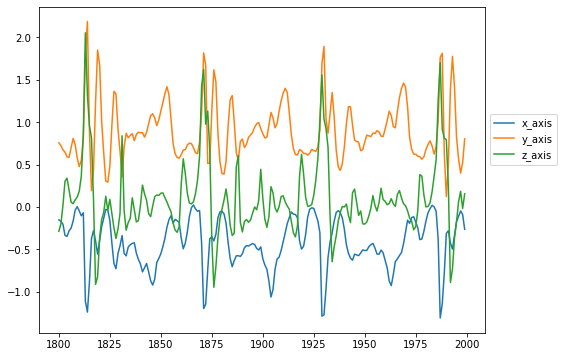

In [75]:
#Plot the acceleration for z's walking
df_wk = read_in_iPhone_data(file='z_walk1.csv')
plot_activity(df_wk,sensor=4)

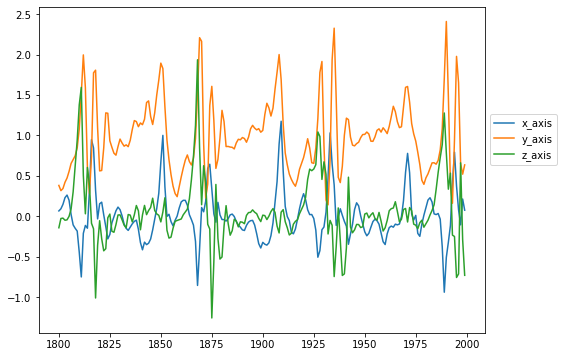

In [77]:
#Plot the acceleration for d's walking
df_wk = read_in_iPhone_data(file='d_walk1.csv')
plot_activity(df_wk,sensor=4)

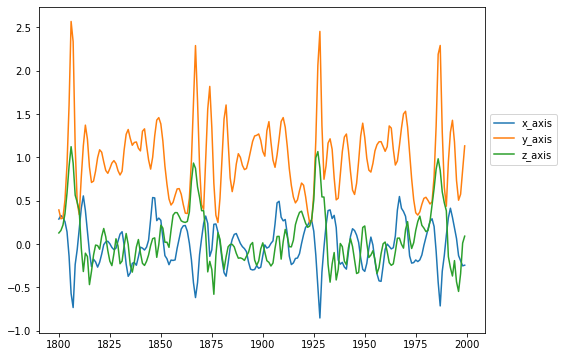

In [79]:
#Plot the acceleration for l's walking
df_wk = read_in_iPhone_data(file='l_walk1.csv')
plot_activity(df_wk,sensor=4)

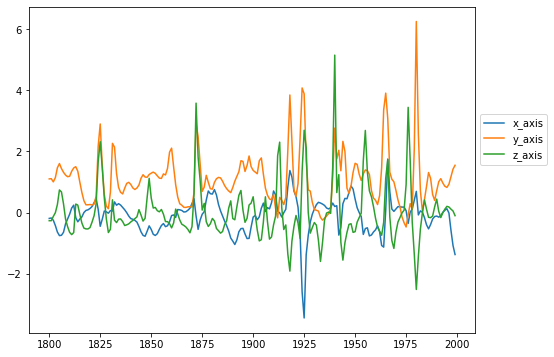

In [78]:
#Plot the acceleration for b's walking
df_wk = read_in_iPhone_data(file='b_walk1.csv')
plot_activity(df_wk,sensor=4)

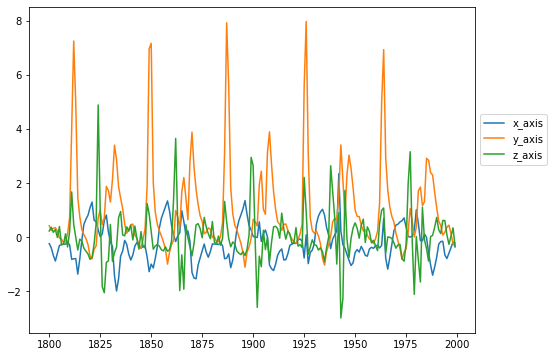

In [76]:
#Plot the acceleration for d's jogging
df_wk = read_in_iPhone_data(file='d_jogging1.csv')
plot_activity(df_wk,sensor=4)

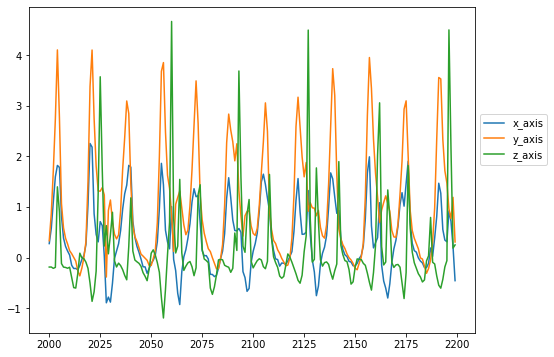

In [71]:
#Plot the acceleration for z's jogging
df_wk = read_in_iPhone_data(file='z_jogging1.csv')
plot_activity(df_wk,sensor=4)

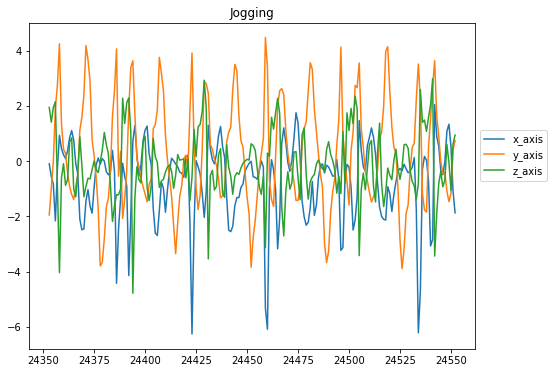

In [163]:
#Plot the acceleration for the walking data from in the training datasets
plot_activity(df_ms_train[(df_ms_train['user_id']==50)], activity = 'Jogging', sensor=4)

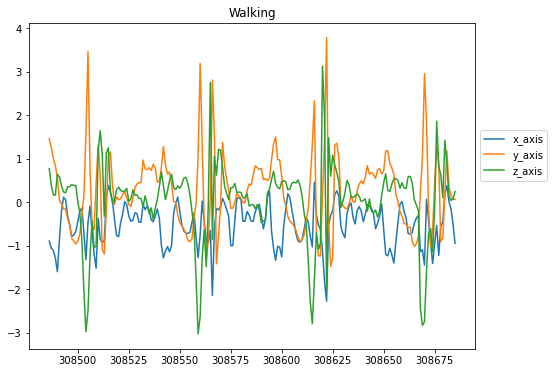

In [167]:
plot_activity(df_ms_train[(df_ms_train['user_id']==55)], activity = 'Walking', sensor=4)

**Comments**
- Walking data in the new collected data had similar patterns as the training datasets
- Jogging data in the new collected data had different patterns from the training dataset, e.g. d's jogging had much less peaks than the training datasets.

<a name="3ml"></a>
### 3. Transfer learning on top of the CNN Models

In [334]:
collection_list = ['b_walk1.csv','d_walk1.csv','d_walk2.csv','l_walk1.csv','z_walk1.csv','z_walk2.csv','d_jogging1.csv','z_jogging1.csv']

In [227]:
# define a function to create model building datasets from the data collected by myself
def create_mbdata_4_iphone(file,activity):
    #input: file -> the file name of collected data
    #       activiy -> the activity for the corresponding data in file
    #output: The model building for CNN and the corresponding label
    
    label_dict= {'Downstairs':[1,0,0,0,0,0],
                 'Jogging':[0,1,0,0,0,0],
                 'Sitting':[0,0,1,0,0,0],
                 'Standing':[0,0,0,1,0,0],
                 'Upstairs':[0,0,0,0,1,0],
                 'Walking':[0,0,0,0,0,1]      
    }
    df = read_in_iPhone_data(file=file)
    df = robustscale_data(df,['x_axis', 'y_axis', 'z_axis'])
    TIME_STEPS = 200
    STEP = 40

    X_add = create_dataset_X(
                df[df.columns[-3:]],
                TIME_STEPS,
                STEP
            )
    X_add_rs = np.array(X_add).reshape(X_add.shape[0],X_add.shape[1],X_add.shape[2],1)
    y_add_train = np.tile(np.array(label_dict[activity]),(X_add_rs.shape[0],1))
    return X_add_rs, y_add_train

In [343]:
#Create model building data from the collected datasets for two activities
X_zwalk,y_zwalk = create_mbdata_4_iphone('z_walk1.csv','Walking')
X_djog,y_djog = create_mbdata_4_iphone('d_jogging1.csv','Jogging')
X_zjog,y_zjog = create_mbdata_4_iphone('z_jogging1.csv','Jogging')

In [344]:
print(X_walk.shape,X_djog.shape,X_zjog.shape)

(345, 200, 3, 1) (593, 200, 3, 1) (634, 200, 3, 1)


In [345]:
#Create the model building datasets from data collected by myself
X_add_cb = np.concatenate((X_walk,X_djog[:150],X_zjog[:200]),axis = 0 )
y_add_cb = np.concatenate((y_walk,y_djog[:150],y_zjog[:200]),axis = 0 )
print(X_add_cb.shape,y_add_cb.shape)

(695, 200, 3, 1) (695, 6)


In [346]:
#The structure of the CNN built from the combined MS and WISDM datasets
model_cb.summary()

Model: "sequential_15"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_14 (Conv2D)           (None, 200, 3, 128)       1280      
_________________________________________________________________
conv2d_15 (Conv2D)           (None, 200, 3, 64)        73792     
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 100, 3, 64)        0         
_________________________________________________________________
conv2d_16 (Conv2D)           (None, 100, 3, 64)        36928     
_________________________________________________________________
conv2d_17 (Conv2D)           (None, 100, 3, 32)        18464     
_________________________________________________________________
max_pooling2d_8 (MaxPooling2 (None, 50, 3, 32)         0         
_________________________________________________________________
conv2d_18 (Conv2D)           (None, 50, 3, 32)       

In [288]:
#Pop out the last layer of the CNN model
model_cb.pop()

In [289]:
#Make sure the last layer was popped out
model_cb.summary()

Model: "sequential_15"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_14 (Conv2D)           (None, 200, 3, 128)       1280      
_________________________________________________________________
conv2d_15 (Conv2D)           (None, 200, 3, 64)        73792     
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 100, 3, 64)        0         
_________________________________________________________________
conv2d_16 (Conv2D)           (None, 100, 3, 64)        36928     
_________________________________________________________________
conv2d_17 (Conv2D)           (None, 100, 3, 32)        18464     
_________________________________________________________________
max_pooling2d_8 (MaxPooling2 (None, 50, 3, 32)         0         
_________________________________________________________________
conv2d_18 (Conv2D)           (None, 50, 3, 32)       

In [290]:
#Add the CNN model as the base model, Freeze the it
base_model = model_cb
base_model.trainable = False

In [308]:
base_model.trainable

False

In [354]:
# Build a new CNN model on top of the base model
cnn_model_new = Sequential()
cnn_model_new.add(base_model)
# Add a densely-connected layer with 16 neurons.
cnn_model_new.add(Dense(16, activation='relu'))

# Let's try to avoid overfitting!
cnn_model_new.add(Dropout(0.4))

# Add a final layer with 6 neurons.
cnn_model_new.add(Dense(6, activation='softmax'))

# Compile model
cnn_model_new.compile(loss='categorical_crossentropy',
                    optimizer='adam',
                    metrics=['accuracy'])

In [355]:
# Fit model with the data collected by myself
history = cnn_model_new.fit(X_add_cb,
                          y_add_cb,
                          batch_size=32,
                          validation_split=0.2,
                          epochs=30,
                          verbose=1)

Epoch 1/30
18/18 [==============================] - 1s 43ms/step - loss: 6.5717 - accuracy: 0.2230 - val_loss: 0.4322 - val_accuracy: 0.8993
Epoch 2/30
18/18 [==============================] - 1s 37ms/step - loss: 4.9754 - accuracy: 0.2950 - val_loss: 0.2875 - val_accuracy: 0.9281
Epoch 3/30
18/18 [==============================] - 1s 37ms/step - loss: 3.3761 - accuracy: 0.4047 - val_loss: 0.2261 - val_accuracy: 0.9281
Epoch 4/30
18/18 [==============================] - 1s 37ms/step - loss: 2.6664 - accuracy: 0.4622 - val_loss: 0.1931 - val_accuracy: 0.9353
Epoch 5/30
18/18 [==============================] - 1s 37ms/step - loss: 1.9049 - accuracy: 0.5935 - val_loss: 0.1779 - val_accuracy: 0.9496
Epoch 6/30
18/18 [==============================] - 1s 37ms/step - loss: 1.5666 - accuracy: 0.6259 - val_loss: 0.1639 - val_accuracy: 0.9712
Epoch 7/30
18/18 [==============================] - 1s 37ms/step - loss: 1.6939 - accuracy: 0.6367 - val_loss: 0.1397 - val_accuracy: 0.9784
Epoch 8/30
18

In [349]:
# The CNN model built from the combined MS and WISDM datasets (only 3 features are available for combined datasets)
model_cb = tf.keras.models.load_model('./02_models/1002cb_cnn_md_3lay_epo20.h5')

In [359]:
#Evaluate the collected data by the model built from the combined MS and WISDM datasets
#Here, I have collected 8 activities 4 subjects. The file first letter of the file name stands for the id of the subject, then the activity.
#Some of the activies of a subject were collected multiple times, so that there is a number followed the activies in the name.
#All the files were collected by putting the iPhone in the right pocket of trousers (The same as the MS datasets).

collection_list = ['b_walk1.csv','d_walk1.csv','d_walk2.csv','l_walk1.csv','z_walk2.csv','d_jogging1.csv','z_jogging1.csv']

acc_old = 0
acc_new = 0
num = 0
for i, act in enumerate(collection_list):
    if i>=5:
        act_name = 'Jogging'
    else:
        act_name = 'Walking'
        
    df = read_in_iPhone_data(file=act)
    df = robustscale_data(df,['x_axis', 'y_axis', 'z_axis'])
    
    TIME_STEPS = 200
    STEP = 40

    X_test = create_dataset_X(
        df[df.columns[-3:]],
        TIME_STEPS,
        STEP
    )
    X_test_rs = np.array(X_test).reshape(X_test.shape[0],X_test.shape[1],X_test.shape[2],1)
    print(f"Combine CNN model's accuracy for {act} is:")
    print(np.mean(np.array(map_preds(model_cb.predict(X_test_rs)))==act_name))
    print(f"Combine CNN model with transfer learning's accuracy for {act} is:")
    print(np.mean(np.array(map_preds(cnn_model_new.predict(X_test_rs)))==act_name))
    print("\n")
    acc_old += X_test_rs.shape[0]*np.mean(np.array(map_preds(model_cb.predict(X_test_rs)))==act_name)
    acc_new += X_test_rs.shape[0]*np.mean(np.array(map_preds(cnn_model_new.predict(X_test_rs)))==act_name)
    num += X_test_rs.shape[0]
ACC_old = acc_old/num
ACC_new = acc_new/num

print(f"The overall accuracy from combined CNN model is: {ACC_old}")
print(f"The overall accuracy from combined CNN model with transfer learning is: {ACC_new}")

Combine CNN model's accuracy for b_walk1.csv is:
0.9176470588235294
Combine CNN model with transfer learning's accuracy for b_walk1.csv is:
0.9794117647058823


Combine CNN model's accuracy for d_walk1.csv is:
0.6589147286821705
Combine CNN model with transfer learning's accuracy for d_walk1.csv is:
0.9302325581395349


Combine CNN model's accuracy for d_walk2.csv is:
0.38271604938271603
Combine CNN model with transfer learning's accuracy for d_walk2.csv is:
0.9654320987654321


Combine CNN model's accuracy for l_walk1.csv is:
0.27204030226700254
Combine CNN model with transfer learning's accuracy for l_walk1.csv is:
0.9596977329974811


Combine CNN model's accuracy for z_walk2.csv is:
0.7338709677419355
Combine CNN model with transfer learning's accuracy for z_walk2.csv is:
0.946236559139785


Combine CNN model's accuracy for d_jogging1.csv is:
0.01011804384485666
Combine CNN model with transfer learning's accuracy for d_jogging1.csv is:
0.9881956155143339


Combine CNN model's accura

In [357]:
#Save the model after transfer learning
cnn_model_new.save('./02_models/1005cb_cnn_md_3lay_epo20_tl.h5')

**Comments**
- Using the collected data to train a new model on top of the pre-trained CNN model was fast
- The new trained model's accuracy of classifing the activities on the collected data was significantly improved:
| Models      	| Subject b walking 1 	|Subject d walking 1 	|Subject d walking 2 	|Subject l walking 1 	|Subject z walking 2 	|Subject d jogging 1 	|Subject z jogging 1	|   
|-------------	|-------	|------	|----------	|----------	|----------	|----------	|----------	|
| Pretrained CNN model   	| 0.92  	| 0.66 	| 0.38     	|0.27     	|0.73     	|0.01     	|0.03     	|
| New model 	| 0.98  	| 0.93 	| 0.97     	|0.96     	|0.95     	|0.99     	|0.98     	|